## 5.

Para este ejercicio, considere el conjunto de datos `training_data.csv`

El cual consiste en mediciones de ciertas variables asociadas a una especie de árboles llamados Scots pine, los cuales están siendo estudiados en una investigación en curso llevada a cabo por Jarislow Socha, profesor de la Universidad de Crakovia en Polonia. Las variables en este estudio son las siguientes:

* Class: Variable binaria que tiene las clases (0- arbol sin muerte ó 1-árbol muerto) 
* Age: Edad del árbol 
* Si: Indice del sitio
* Dens: Densidad
* Aspect: Aspecto del árbol 
* Shannon: Indice de Shannon
* X: Coordenada X
* Y: Coordenada Y
* Z: Altitud

El objetivo del estudio es determinar si basados en las últimas 7 variables es posible predecir si el árbol está muerto o no $(Class=0 ó 1 )$.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import altair as alt

In [2]:
df = pd.read_csv('./data/training_data.csv', sep = ';', decimal = ',')
df.head()

,class,age,si,dens,aspect,shannon,x,y,z
0,0,80,29.31,312.168518,178.162415,0.403482,539396.023230,342014.421747,244.010391
1,0,92,23.61,426.017151,215.833481,0.402393,513721.151135,321344.473021,263.736542
2,0,87,27.33,325.270660,258.477692,0.498532,502974.022211,299925.134450,308.940857
3,0,92,31.39,142.403732,172.111496,0.440584,420756.322079,330057.461534,173.054001
4,0,79,30.56,269.491028,198.696793,0.557561,524926.468639,287904.381589,345.006927


In [3]:
df.dtypes

class        int64
age          int64
si         float64
dens       float64
aspect     float64
shannon    float64
x          float64
y          float64
z          float64
dtype: object

1. Determine en este contexto si es posible reducir la dimensión del problema a tratar usando componentes principales y algunas técnicas de visualización.

Primero revisemos como se dividen las clases

In [4]:
df.groupby('class').apply(lambda x: x['class'].count())

class
0    2514
1    2547
dtype: int64

Podemos ver que estás están divididas de forma relativamente equitativa. 

Ahora realizaremos una visualización rápida de los datos usando boxplots.

<AxesSubplot:>

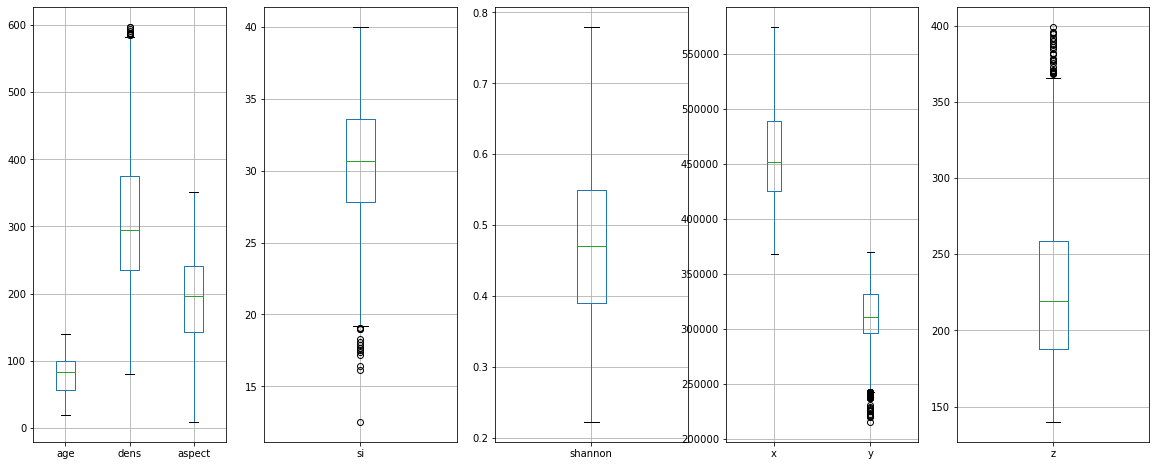

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,8))
df[['age', 'dens', 'aspect']].boxplot(ax=axes[0])
df[['si']].boxplot(ax=axes[1])
df[['shannon']].boxplot(ax=axes[2])
df[['x', 'y']].boxplot(ax=axes[3])
df[['z']].boxplot(ax=axes[4])

A primera vista podemos ver que los datos están en ordenes de magnitud muy dis tintas, pero todos aparentan tener distribuciones relativamente centradas. 

In [6]:
X = df[['age', 'si', 'dens', 'aspect', 'shannon', 'x', 'y', 'z']]
y = df['class']

In [7]:
from pca import pca

model = pca(n_components=0.99)
results = model.fit_transform(X)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [99.0%] explained variance using the [8] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [2] that covers the [99.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


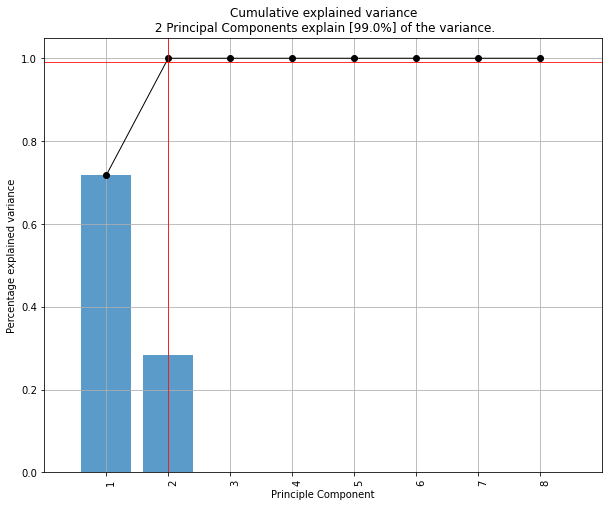

<Figure size 432x288 with 0 Axes>

In [8]:
fig, ax = model.plot()

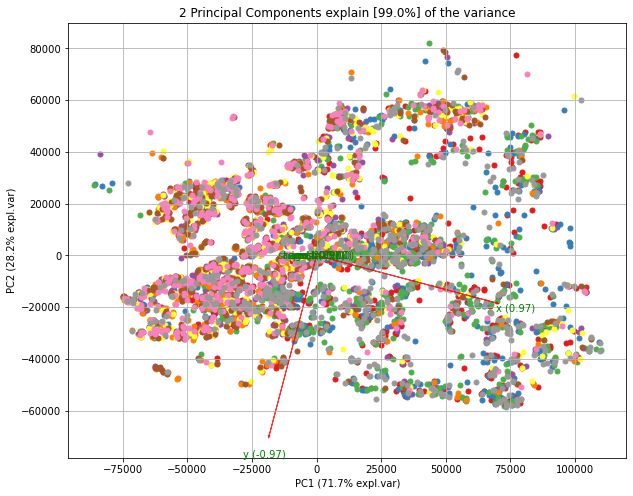

In [9]:
fig, ax = model.biplot(n_feat=8, legend=False, label = False)

In [10]:
results['PC']

,PC1,PC2
0,69731.436121,-51451.100373
1,50174.921526,-24918.468528
2,45243.853734,-1466.876380
3,-41939.286225,-9641.758416
4,69535.574426,4559.876821
...,...,...
5056,-23156.185472,19297.433321
5057,-21195.319957,-6590.745119
5058,-22378.809911,-5684.315252
5059,40706.140496,11088.312583


Podemos ver que mantenemos un 99% de fidelidad a los datos usando tan solo 2 componentes principales. Además graficando los datos tenemos:

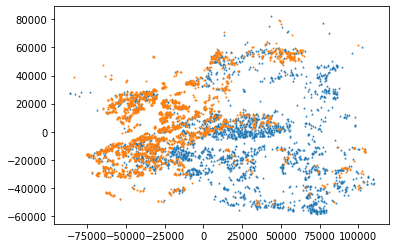

In [11]:
source = results['PC']
source['class'] = y

vivos = source[source['class']==0]
muertos = source[source['class']==1]


plt.scatter(vivos.PC1, vivos.PC2, s=1, marker='^')
plt.scatter(muertos.PC1, muertos.PC2,s=1,  marker='o')


plt.show()

### b)
Usando la regla de Bayes, cuál sería la predicción para la variable class para un árbol en que se obtiene la siguiente observación:
* Age $=80$; 
* $\mathrm{Si}=34.17$;
* Dens $=394.03$; 
* Aspect $=200.56$ 
* $\mathrm{X}=469238.238087984$;
* $\mathrm{Y}=335326.667325$;
* $\mathrm{Z}=267.824157714844$

Usamos el Bayes Gausiano que nos entrega `sklearn`

In [12]:
from sklearn.naive_bayes import GaussianNB #importamos el modelo

X_0 = X[['age', 'si', 'dens', 'aspect', 'x', 'y', 'z']] #preparamos los datos (notemos que la nueva observación no tiene `Shannon`)
gnb = GaussianNB() #planteamos el modelo
gnb.fit(X_0, y) #lo entrenamos
gnb.predict(np.array([80, 34.17, 394.03, 200.56, 469238.238087984, 335326.667325, 267.824157714844]).reshape(1, -1)) # realizamos la predición 

array([0], dtype=int64)

Tenemos que la nueva medición pertenece a categoría "*arbol sin muerte*"

### c)
Construya un modelo de regresión logística considerando el conjunto de datos como una muestra de entrenamiento. Comente el ajuste del modelo y realice un análisis de la bondad del ajuste.

Usaremos `LogisticRegression` de `sklearn`. Probaremos con los datos en bruto y los datos con luego de realizar la reducción de dimensión con PCA

#### Con datos Orgininales

In [13]:
from sklearn.linear_model import LogisticRegression #importamos el modelo

clf  = LogisticRegression(random_state=42) #plantemos el modelo 
clf.fit(X, y) #entrenamos el modelo
clf.coef_

array([[ 6.94684889e-02,  2.23337708e-04,  2.97713608e-03,
         1.84860325e-03,  1.83279537e-04, -1.21326954e-06,
        -1.35832265e-06, -2.58583972e-02]])

Ahí tenemos los parámetros del modelo

In [14]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X)
accuracy_score(y, y_pred)

0.8199960482118158

#### Con datos PCA

In [15]:
from sklearn.metrics import plot_confusion_matrix

clf_PCA  = LogisticRegression(random_state=42) #plantemos el modelo 
clf_PCA.fit(results['PC'], y) #entrenamos el modelo
clf_PCA.coef_

array([[-2.94393924e-05,  2.35049448e-05,  1.32687896e-08]])

Ahí tenemos los parámetros del modelo

In [16]:
y_pred_PCA = clf_PCA.predict(results['PC'])
accuracy_score(y, y_pred_PCA)

0.7516301126259632

Podemos ver basados en la presición de los modelos, que el modelo al que no se le redujo la dimensionalidad performó mejor que al que se le aplico PCA, pero la presición no es todo, por lo que realizaremos un análisis con *confusión matrix*

Text(-3.3, -0.7, 'Datos Originales')

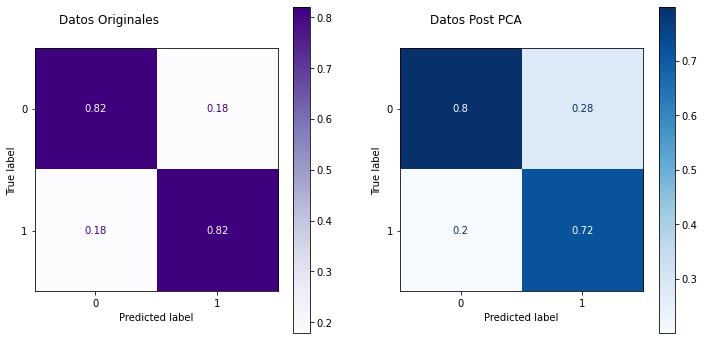

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax = plot_confusion_matrix(clf, X, y,
                          cmap=plt.cm.Purples,
                          normalize='pred',
                          ax=axes[0]
                     )

ax = plot_confusion_matrix(clf_PCA, results['PC'], y,
                          cmap=plt.cm.Blues,
                          normalize='pred',
                          ax=axes[1],
                     )

plt.text(-0.25, -0.7, 'Datos Post PCA',fontsize=12)
plt.text(-3.3, -0.7, 'Datos Originales',fontsize=12)

Podemos ver que en todos los frentes la regresión que usa los datos originales clasifica mejor que el modelo al que se le hizo PCA.

### d)
Agrupe los árboles de acuerdo a alguna técnica apropiada. Incluya en su análisis la determinación del número de clusters a considerar

Utilizaremos `KMeans` para realizar el clustering, para determinar la canidad de clusters que usaremos, con el objetivo de facilitar el análisis utilizaremos los datos luego de aplicar la reducción a 2 dimensiónes con componentes principales. 

Para n_clusters = 2 La silhouette_score promedio es : 0.461622831687442
Para n_clusters = 3 La silhouette_score promedio es : 0.44209709100326006
Para n_clusters = 4 La silhouette_score promedio es : 0.4127685928634849
Para n_clusters = 5 La silhouette_score promedio es : 0.41006363324510225


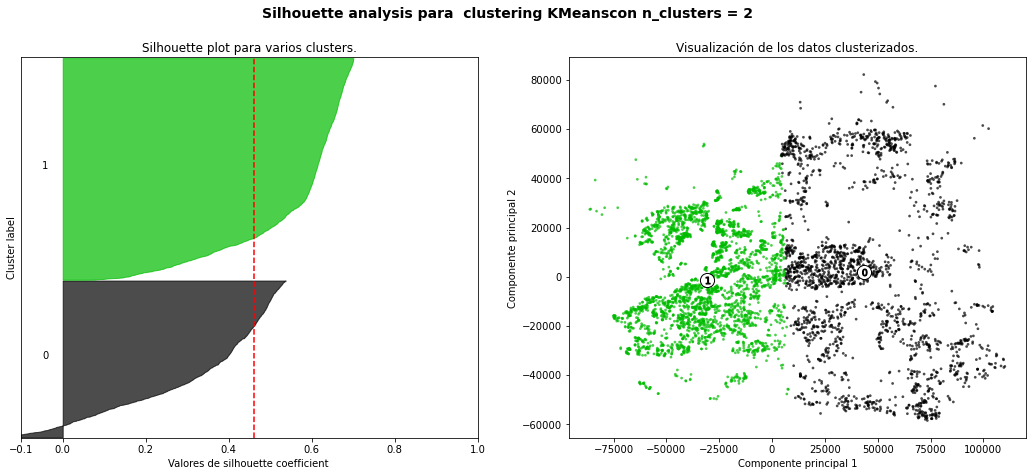

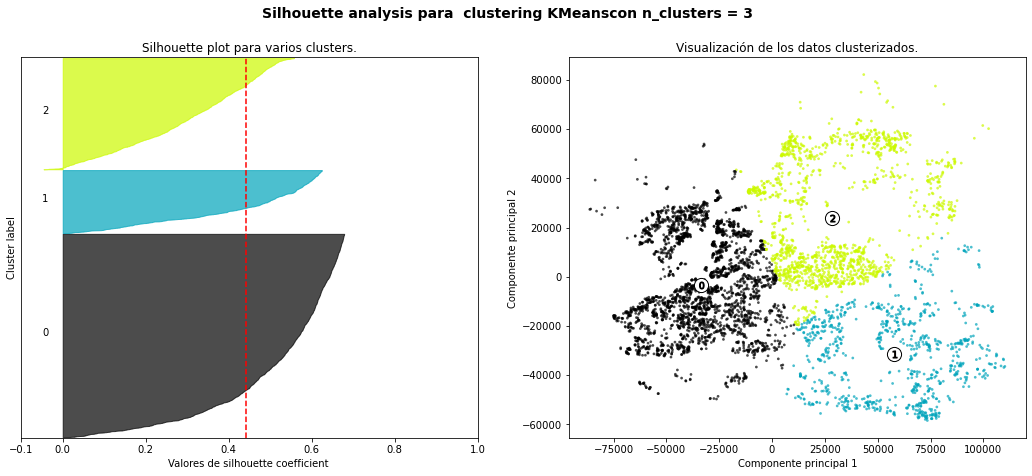

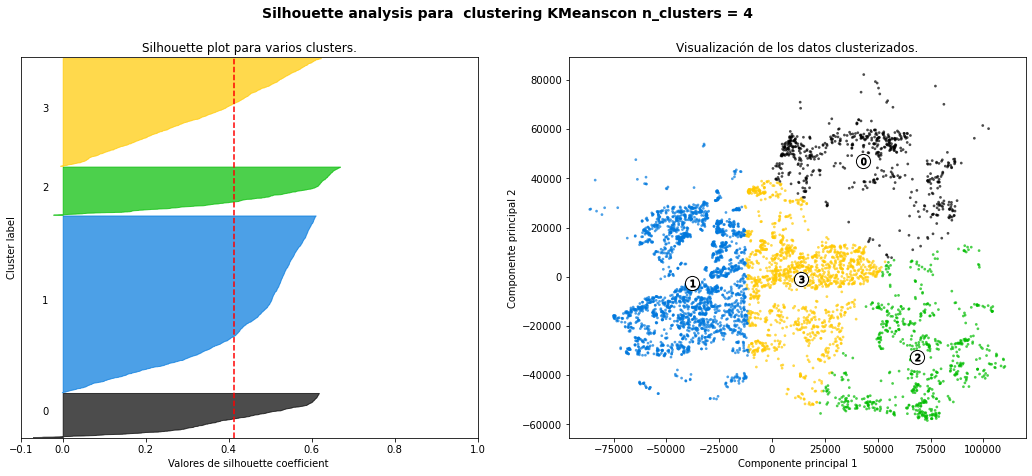

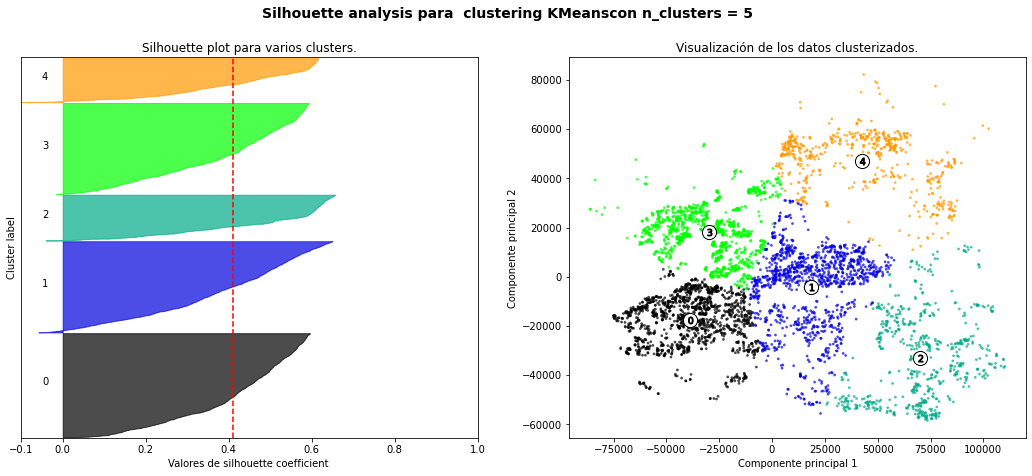

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm
import numpy as np


X = np.array(results['PC']) #utu

range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # iniciamos el algoritmos de clustering
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "La silhouette_score promedio es :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):

        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)


        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))


        y_lower = y_upper + 10 

    ax1.set_title("Silhouette plot para varios clusters.")
    ax1.set_xlabel("Valores de silhouette coefficient ")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualización de los datos clusterizados.")
    ax2.set_xlabel("Componente principal 1")
    ax2.set_ylabel("Componente principal 2")

    plt.suptitle(("Silhouette analysis para  clustering KMeans"
                  "con n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Dado esto, podemos ver que el numero de clusters a elegir es entre 2 y 3. En particular una clusterización de 3 grupos me parece razonable. Recordemos la distribución de los arboles.

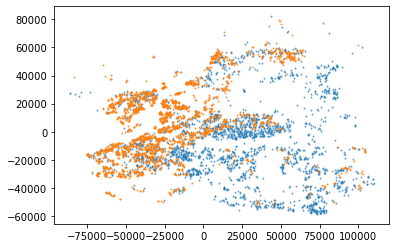

In [19]:
source = results['PC']
source['class'] = y

vivos = source[source['class']==0]
muertos = source[source['class']==1]


plt.scatter(vivos.PC1, vivos.PC2, s=1, marker='^', alpha=0.7)
plt.scatter(muertos.PC1, muertos.PC2,s=1,  marker='o', alpha=0.7)


plt.show()

### e)
Escriba comentarios finales de lo que observa

* Los datos son un claro ejemplo de cuando la reducción de dimensionalidad puede facilitar inmensamente el analisis de los mismos 
* Dada la distribucción de los arboles, no parece que usar *K-means* no es una buena forma de clasificar los arboles como vivos o muertos
* A pesar de que al realizar PCA se mantiene más del 99% de la información, la regrsión logística performa mejor en los datos orginiales, y no una cantidad peor 
* Hay muchos estudios futuros que hacer y hay más metodos que probar.